<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Profesora: María Paz Raveau Morales</em><br>

</div>

# **<center>TAREA 2 COMPARANDO TOPIC MODELING Y CLUSTERING</center>**
*03 de agosto de 2025*

**Nombre Estudiante**: Cristian Tobar Morales  
**Asignatura**: Procesamiento de Lenguaje Natural


## **DESCRIPCIÓN DE LA PROBLEMÁTICA**
 

## **OBJETIVOS**

## **DESARROLLO**

### **CARGA Y ANÁLISIS EXPLORATORIO DE LOS DATOS**

#### Librerías requeridas

In [1]:
import os
%matplotlib inline
import pandas as pd
import numpy as np
import math


import string
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from nltk import bigrams

remove_punct_map = dict.fromkeys(map(ord, string.punctuation))
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
from itertools import compress

import re

# visualización 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import stanza
stanza.download('es') # Ejecutar solamente una vez
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma,depparse')

2025-08-04 15:40:20 INFO: Downloaded file to C:\Users\crist\stanza_resources\resources.json
2025-08-04 15:40:21 INFO: Downloading default packages for language: es (Spanish) ...
2025-08-04 15:40:23 INFO: File exists: C:\Users\crist\stanza_resources\es\default.zip
2025-08-04 15:40:27 INFO: Finished downloading models and saved to C:\Users\crist\stanza_resources
2025-08-04 15:40:27 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-08-04 15:40:38 INFO: Downloaded file to C:\Users\crist\stanza_resources\resources.json
2025-08-04 15:40:39 INFO: Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2025-08-04 15:40:39 INFO: Using device: cpu
2025-08-04 15:40:39 INFO: Loading: tokenize
2025-08-04 15:40:56 INFO: Loading: mwt
2025-08-04 15:40:56 INFO: Loading: pos
2025-08-04 15:40:58 INFO: Loading: lemma
2025-08-04 15:41:00 INFO: Loading: depparse
2025-08-04 15:41:00 INFO: Done loading processors!


In [3]:
import nltk
nltk.download('punkt') # Ejecutar solamente una vez

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\crist\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from nltk import word_tokenize
from nltk.corpus import stopwords
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop + ['ser','tener','deber','haber','hacer','poder','ir']
esp_stop.remove('estado')
esp_stop.remove('estados')

In [5]:
import gensim
from gensim import corpora
from gensim import models

#### Cargar e Información inicial del dataset

In [79]:
# Leer cada línea como una entrada de texto
with open('ecqq.csv', encoding='utf-8') as f:
    lines = f.readlines() # lee el archivo completo como una lista de líneas

# Limpiar saltos de línea y espacios
lines = [line.strip() for line in lines if line.strip()]

# Crear DataFrame con una sola columna
df = pd.DataFrame(lines, columns=['texto'])

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10204 entries, 0 to 10203
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   10204 non-null  object
dtypes: object(1)
memory usage: 79.8+ KB


In [81]:
# Exploración inicial
df['texto'].head().to_list()

['P2_1_B',
 '0\tse necesitan pensiones dignas a los adultos mayores, ya que no alcanza el costo de vida tan alto en que que vivimos',
 '1\tel acceso a la salud sea de calidad, con diagnosticos que generen confianza no debiendo ir a santiago para conseguir confianza. altos costos de los servicios.',
 '2\t"conprender que el trabajo es una ""actividad"" y no un ""lugar físico"", a partir de ello, la incorporación de la flexibilidad laboral permite generar mayor motivación.',
 'junto con ello, asimilar a trabajadores honorarios como aquellos que cuentan con cto indefinido y no como trabajadores de 2° categori"']

Se seleccionan distintas filas del corpus con el objetivo de revisar la data cruda y comprender el tipo de información compartida, como paso previo al procesamiento.

In [47]:
import random

for i in range(8):
    print(f"\033[1m TEXTO {i}:\033[0m")
    print(df.loc[random.randint(0, len(df))]['texto'], end="\n")

 TEXTO 0:
3792	pensiones dignas, que nos permitan vivir dignidad, pensiones actuales no nos permiten llegar el mundo de la culturas, cine, libros , porque se nos esta vetando
 TEXTO 1:
4074	"- urgencia, no es urgencia
 TEXTO 2:
demora en examen (servicios)
 TEXTO 3:
2978	"mala reforma de pensiones no esta de acuerdo con el aumento
 TEXTO 4:
956	"-salud pública no permite que las personas puedan atenderse oportunamente y salud digna.
 TEXTO 5:
1314	"educación digna y de calidad que sea transversal
 TEXTO 6:
1110	"que se potencia a carabineros y se renueve completamente.
 TEXTO 7:
- Mecanismo de rentabilidad estable


En las filas seleccionadas de forma aleatoria se observa que los ciudadanos realizan solicitudes al Estado sobre su calidad de vida, ya sea para llevar una existencia tranquila y digna o para acceder a una pensión adecuada.

### **PRE-PROCESAMIENTO**

In [82]:
# Crear una nueva columna
columna = "texto_modificado"
df[columna] = df['texto']

In [83]:
# Saber que entradas no aportan información
df[columna].value_counts().head(15)

texto_modificado
"                           109
falta de especialistas        8
-falta de especialistas       6
especialistas                 5
- falta de especialistas      5
falta de especialistas.       5
- mas especialistas           4
- falta de insumos            3
lista de espera               3
listas de espera              3
-falta de medicamentos        3
- falta de especialista       3
-"                            3
- lista de espera             3
- calidad                     3
Name: count, dtype: int64

In [84]:
# Eliminar las filas que no aportar información
"""
Se procede a eliminar las filas (")
"""
df= df[(df[columna].str.strip() != '"') & (df[columna].str.strip() != '-"')]

df[columna].value_counts().head(15)

texto_modificado
falta de especialistas      8
-falta de especialistas     6
- falta de especialistas    5
falta de especialistas.     5
especialistas               5
- mas especialistas         4
lista de espera             3
- falta de especialista     3
- calidad                   3
- lista de espera           3
listas de espera            3
- falta de insumos          3
-falta de medicamentos      3
mala atención.              2
mejor atención              2
Name: count, dtype: int64

In [85]:
# Eliminar la primera fila
# Quitar la fila 0
df = df[df[columna] != 'P2_1_B']

In [86]:
# Obtener valores únicos
df.drop_duplicates(
    subset=[columna],
    keep='first', # Conserva la primera ocurrencia
    inplace= True
)
print("\u001b[1mDIMENSIONES\u001b[0m")
df.shape

DIMENSIONES


(9988, 2)

#### Tokenizar

In [87]:
corpus = ' '.join(df[columna].to_list()) # Unir el texto con un espacio y to_list, obtiene la lista
doc =  set(word_tokenize(corpus))
largo = len(doc)
# imprimir
print(f"Tokens únicos: {largo}")


Tokens únicos: 13435


#### Lemmatizar

In [88]:
def lemmatizer(text):
    doc = nlp(text)
    return ' '.join([
        word.lemma 
        for sent in doc.sentences
            for word in sent.words
                if word.lemma not in esp_stop])

In [89]:
df[columna]= df[columna].apply(lemmatizer)

#### Transformar el texto en minúsculas, eliminar puntuaciones, números, espacios en blanco y salto de líneas

In [90]:
# Transformar a minúscula
df[columna] = df[columna].str.lower()

# Eliminar las puntuaciones: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
df[columna] = df[columna].str.translate(str.maketrans('','', string.punctuation))

# Eliminar números
df[columna] = df[columna].str.translate(str.maketrans('', '', string.digits))

# Eliminar espacios en blanco
df[columna] = df[columna].str.strip()

# Reemplazar saltos de líneas por espacios
df[columna] = df[columna].str.replace('\n',' ')

In [91]:
df.shape

(9988, 2)

In [92]:
df[columna].head().to_list()

['necesitar pensión digno adulto mayor  alcanzar costo vida alto vivir',
 'acceso salud calidad  diagnostico generar confianza santiago conseguir confianza  alto costo servicio',
 'conprender trabajo   actividad     lugar físico    partir  incorporación flexibilidad laboral permitir generar mayor motivación',
 'junto  asimilar trabajador honorario aquel contar cto indefinido trabajador ° categori',
 'especialista consultorio  escaso llevar hora espera interminable']

#### Stopwords

In [93]:
# Tokenizar el texto
tokens = set(word_tokenize(' '.join(df[columna].to_list())))

# Eliminar Stopwords
filtrado = [x for x in tokens if x not in esp_stop]

len(filtrado)

4991

Se procede al guardado del archivo preprocesado.

In [94]:
df.to_csv('ecqq_preprocesados.csv', sep='\t')

-------------------------

Se carga el archivo previamente procesado con el fin de realizar el análisis temático mediante el modelo LDA. Este archivo contiene el corpus limpio y tokenizado, listo para ser transformado en una representación de bolsa de palabras y utilizado en la etapa de modelado.

In [6]:
# Cargar el nuevo dataset
df_limpio = pd.read_csv('ecqq_preprocesados.csv',sep='\t',index_col=0)

Comparar el conjunto de datos original con el preprocesado es fundamental para evaluar la eficacia y exhaustividad del proceso de limpieza de datos.

In [11]:
df_limpio.head()

,texto,texto_modificado
1,0\tse necesitan pensiones dignas a los adultos...,necesitar pensión digno adulto mayor alcanzar...
2,"1\tel acceso a la salud sea de calidad, con di...",acceso salud calidad diagnostico generar conf...
3,"2\t""conprender que el trabajo es una """"activid...",conprender trabajo actividad lugar físic...
4,"junto con ello, asimilar a trabajadores honora...",junto asimilar trabajador honorario aquel con...
5,"3\t""- más especialistas en los consultorios, s...",especialista consultorio escaso llevar hora e...


In [12]:
df_limpio['texto'].head().to_list()

['0\tse necesitan pensiones dignas a los adultos mayores, ya que no alcanza el costo de vida tan alto en que que vivimos',
 '1\tel acceso a la salud sea de calidad, con diagnosticos que generen confianza no debiendo ir a santiago para conseguir confianza. altos costos de los servicios.',
 '2\t"conprender que el trabajo es una ""actividad"" y no un ""lugar físico"", a partir de ello, la incorporación de la flexibilidad laboral permite generar mayor motivación.',
 'junto con ello, asimilar a trabajadores honorarios como aquellos que cuentan con cto indefinido y no como trabajadores de 2° categori"',
 '3\t"- más especialistas en los consultorios, son escasos lo que lleva a horas de espera interminables']

In [14]:
df_limpio['texto_modificado'].head().to_list()

['necesitar pensión digno adulto mayor  alcanzar costo vida alto vivir',
 'acceso salud calidad  diagnostico generar confianza santiago conseguir confianza  alto costo servicio',
 'conprender trabajo   actividad     lugar físico    partir  incorporación flexibilidad laboral permitir generar mayor motivación',
 'junto  asimilar trabajador honorario aquel contar cto indefinido trabajador ° categori',
 'especialista consultorio  escaso llevar hora espera interminable']

In [16]:
import random
for i in range(10):
    print(f"\033[1m TEXTO {i}:\033[0m")
    print(df_limpio.loc[random.randint(0, len(df_limpio))]['texto_modificado'], end="\n")

 TEXTO 0:
cada especialista tomar rol corresponder acuerdo función
 TEXTO 1:
mejorar dar aporte económico
 TEXTO 2:
indolencia  falta empatía profesional salud
 TEXTO 3:
garantizar plan salud bajo costo
 TEXTO 4:
salud igualitario derecho salud gratuito fin lista espera
 TEXTO 5:
reconfianza politico
 TEXTO 6:
partido politico dividido buscar bien comun
 TEXTO 7:
que dirigente generar acuerdo beneficiar  arreglar siempre
 TEXTO 8:
importante buen hospital faltar especialista recurso  remedio execibamente caro
 TEXTO 9:
vez remedio examen


In [7]:
print(df_limpio['texto_modificado'].isna().sum())    # cuenta de NaN
df_limpio.dropna(subset=['texto_modificado'], inplace=True)

16


### **MODELO LDA INCORPORANDO BIGRAMAS**

Latent Dirichlet Allocation (LDA), es un modelo generativo probabilístico que se utiliza para descubrir temas ocultos(topics) en un conjunto de documentos. Al incorporar bigramas en el modelo puede mejorar la calidad de los temas al capturar expresiones compuestas que tiene un significado más específico que las palabras individuales.

In [8]:
from gensim.models import Phrases

# Creación de bigramas
corpus = [word_tokenize(doc) for doc in df_limpio['texto_modificado']]

bigram = Phrases(corpus, min_count=1, threshold=1) # min_count, ignora bigramas con menos de 5 apariciones

for x in range(len(corpus)):
    for token in bigram[corpus[x]]:
        if '_' in token:
            corpus[x].append(token) # Agrega el token al corpus

In [9]:
# Imprime los primeros 3 documentos completos
for i, doc in enumerate(corpus[:4]):
    print(f"--- Documento {i} ---")
    print(doc, end="\n\n")

--- Documento 0 ---
['necesitar', 'pensión', 'digno', 'adulto', 'mayor', 'alcanzar', 'costo', 'vida', 'alto', 'vivir', 'pensión_digno', 'adulto_mayor', 'costo_vida']

--- Documento 1 ---
['acceso', 'salud', 'calidad', 'diagnostico', 'generar', 'confianza', 'santiago', 'conseguir', 'confianza', 'alto', 'costo', 'servicio', 'acceso_salud', 'alto_costo']

--- Documento 2 ---
['conprender', 'trabajo', 'actividad', 'lugar', 'físico', 'partir', 'incorporación', 'flexibilidad', 'laboral', 'permitir', 'generar', 'mayor', 'motivación', 'flexibilidad_laboral', 'permitir_generar']

--- Documento 3 ---
['junto', 'asimilar', 'trabajador', 'honorario', 'aquel', 'contar', 'cto', 'indefinido', 'trabajador', '°', 'categori']



Se extraen todos los bigramas del corpus, la cual están representados como tokens con guiones bajos y se crea el diccionario.

In [ ]:
from gensim.corpora import Dictionary

corpus_bigrams = [ # Corpus de puros bigramas
    [token for token in doc if "_" in token]
    for doc in corpus 
]
diccionario_bigramas = Dictionary(corpus_bigrams)

In [14]:
# Matriz documento-término (DTM)
dtm_gensim = [diccionario_bigramas.doc2bow(i) for i in corpus_bigrams]

In [15]:
# Muestra los 3 primeros documentos en formato BoW
for i, doc_bow in enumerate(dtm_gensim[:3], 1):
    print(f"Doc {i}: {doc_bow}")


Doc 1: [(0, 1), (1, 1), (2, 1)]
Doc 2: [(3, 1), (4, 1)]
Doc 3: [(5, 1), (6, 1)]


In [16]:
print('Número único de tokens: %d' % len(diccionario_bigramas))
print('Número de documentos: %d' % len(dtm_gensim))

Número único de tokens: 3515
Número de documentos: 9972


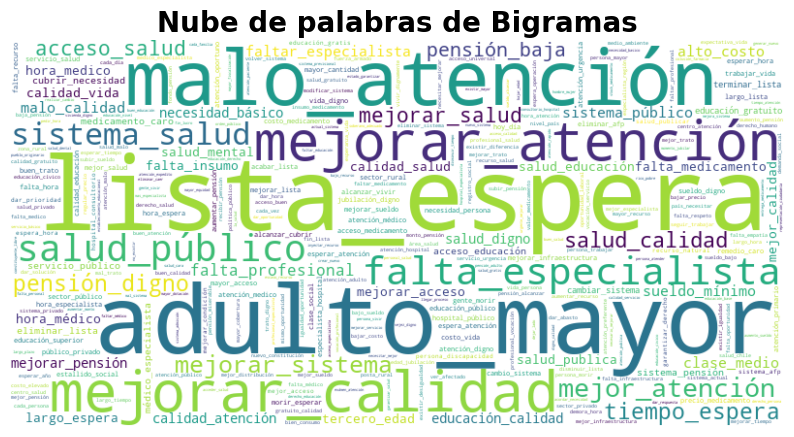

In [18]:
# Visualización del bigrama
from collections import Counter

# Determinar la frecuencia de los bigramas
flat_bigramas = [token for doc in corpus_bigrams for token in doc]
freq_counter = Counter(flat_bigramas)

wc = WordCloud(
    background_color='white',
    width=800,
    height=400,
    max_words=8549
).generate_from_frequencies(freq_counter)

# Mostrar
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de Bigramas', fontsize=20, fontweight='bold')
plt.show()

#### Diagnóstico de tópicos

La perplexity es una métrica que evalúa cuán bien un modelo de temas (como LDA) predice texto no visto. Se puede entender como el número efectivo de “opciones” que el modelo necesita para generar cada palabra del conjunto de prueba.
- Si la perplexity es baja, el modelo asigna probabilidades más altas a las palabras reales y, por lo tanto, “se sorprende” menos al ver los datos de prueba.

- Si es alta, significa que el modelo queda “confundido” y le cuesta predecir las palabras correctamente.

La perplexity mide la capacidad del modelo para predecir texto que nunca ha visto.

Si la calculas sobre el mismo conjunto de entrenamiento, el modelo obtendría una perplexity artificialmente baja porque “recuerda” los documentos.

In [19]:
from sklearn.model_selection import train_test_split
from gensim.models import CoherenceModel
X_train, X_test = train_test_split(corpus_bigrams, train_size=0.9, test_size=0.1, random_state=1)

dic_corpus_train = Dictionary(X_train)
dtm_gensim_train = [dic_corpus_train.doc2bow(i) for i in X_train]

dic_corpus_test = Dictionary(X_test)
dtm_gensim_test = [dic_corpus_test.doc2bow(i) for i in X_test]

n_topics = range(2, 20)

coherencia = []
perplexity = []

for i in n_topics:
    """
    
    i: Número de topicos.
    model2:
    el modelo se ajusta con datos de entrenamiento y 
    la perplexity se calcula con datos de prueba.
    
    Al aplicar 2**(-log_bound), recuperamos la métrica en su escala original.
    Menor perplexity implica mejor ajuste.
    """
    model2 = gensim.models.ldamodel.LdaModel(dtm_gensim_train, 
                                             id2word = dic_corpus_train,
                                             num_topics= i, 
                                             random_state= 42)
    # Calcular y agregar al listado
    perplexity.append(2**(-1*model2.log_perplexity(dtm_gensim_test)))
    
    
    model3 = gensim.models.ldamodel.LdaModel(dtm_gensim,
                                             id2word= diccionario_bigramas, 
                                             num_topics= i,
                                             random_state= 42
        
    )
    
    coherence_model = CoherenceModel(
        model=model3,
        texts=corpus_bigrams,            # lista de documentos tokenizados
        dictionary=diccionario_bigramas,
        coherence='c_v'          # métrica recomendada para LDA
    )
    
    # Agregar coherencia a la lista
    coherencia.append(coherence_model.get_coherence())

Se grafican los resultados de coherencia y perplexity para un rango de 2 a 20 tópicos, con el fin de determinar visualmente el número óptimo de temas para el modelo.

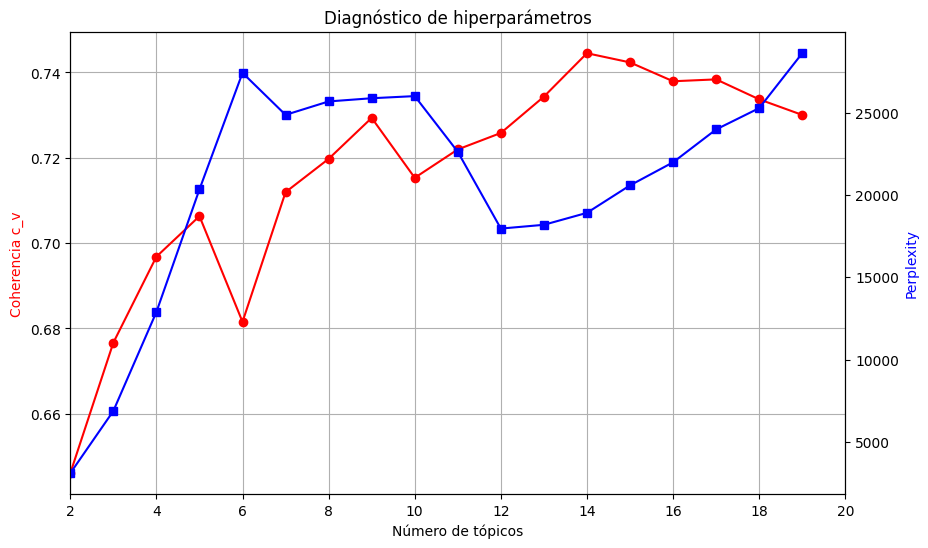

In [ ]:
# Graficar
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax1.plot(n_topics, coherencia, 'r-o', label='Coherencia c_v')
ax2.plot(n_topics, perplexity, 'b-s', label='Perplexity')
ax1.set_xlabel('Número de tópicos')
ax1.set_ylabel('Coherencia c_v', color='r')
ax2.set_ylabel('Perplexity', color='b')

ax1.set_xlim(2, 20)
ax1.grid() # Activar grilla

plt.title('Diagnóstico de hiperparámetros')
plt.show()

De acuerdo con el gráfico de diagnóstico de hiperparámetros, el número ideal de tópicos es 8, ya que:

- Logra el mejor punto de codo en la curva de coherencia (≈ 0.74) y minimiza la perplexity antes de estabilizarse.

- Mantiene alta calidad semántica sin incurrir en sobrecarga de información.

Si bien con 12 tópicos la coherencia sigue siendo alta y la perplexity baja, este incremento provoca:

- Solapamiento de términos clave entre tópicos.

- Dificultad para etiquetar y distinguir claramente cada tema.

- Mayor esfuerzo cognitivo en la interpretación y presentación de resultados.

Se ejecuta el modelo LDA con la cantidad de tópicos (8) seleccionados. 

In [20]:
# Parámetros de entrenamiento
num_topics = 8     # Número de topicos a extraer
chunksize = 1000    # Num de documentos procesados en cada lote
passes = 20         # Cuántas veces recorre todo el corpus
iterations = 200    # Iteraciones de optimización por lote

# Modelo
model = gensim.models.ldamodel.LdaModel(
    corpus= dtm_gensim,     #  representación BoW de tus documentos
    id2word= diccionario_bigramas,   # mapeo id ↔ token
    chunksize= chunksize,
    alpha='auto',
    eta='auto',
    iterations= iterations,
    num_topics= num_topics,
    passes= passes,
    random_state= 42 # fija semilla para reproducibilidad
)

In [50]:
# Encontrar la posición de k=8
idx = n_topics.index(8)

# 2. Extrae los valores
coh_for_8 = coherencia[idx]
perp_for_8 = perplexity[idx]

# 3. Imprimir 
print(f'Coherencia (c_v) para k={8}: {coh_for_8:.4f}')
print(f'Perplexity para k={8}:     {perp_for_8:.2f}')

Coherencia (c_v) para k=8: 0.7197
Perplexity para k=8:     25688.06


- Una coherencia c_v superior a 0.6 suele indicar que los temas son semánticamente sólidos y fáciles de interpretar, lo cual refleja una alta calidad temática en el corpus.

- En cuanto a la perplexity, un valor más bajo denota una mayor capacidad predictiva del modelo sobre el corpus, ya que mide el grado de “sorpresa” ante nuevos datos.

Podemos ver las primeras N palabras, con su peso, para cada tópico:

In [21]:
model.print_topics(num_words=7)

[(0,
  '0.055*"malo_atención" + 0.025*"malo_calidad" + 0.021*"alto_costo" + 0.018*"educación_calidad" + 0.013*"medicamento_caro" + 0.011*"precio_medicamento" + 0.011*"alcanzar_cubrir"'),
 (1,
  '0.017*"hora_medico" + 0.017*"falta_insumo" + 0.017*"calidad_atención" + 0.016*"tercero_edad" + 0.012*"educación_gratuito" + 0.012*"necesidad_persona" + 0.012*"educación_superior"'),
 (2,
  '0.030*"mejorar_salud" + 0.024*"pensión_baja" + 0.016*"mayor_cantidad" + 0.015*"acceso_educación" + 0.015*"eliminar_lista" + 0.014*"servicio_público" + 0.013*"sector_público"'),
 (3,
  '0.049*"falta_especialista" + 0.039*"mejorar_sistema" + 0.021*"mejorar_acceso" + 0.019*"calidad_vida" + 0.019*"falta_medicamento" + 0.019*"salud_mental" + 0.019*"necesidad_básico"'),
 (4,
  '0.062*"adulto_mayor" + 0.026*"salud_público" + 0.018*"pensión_digno" + 0.017*"salud_calidad" + 0.017*"tiempo_espera" + 0.013*"sueldo_mínimo" + 0.012*"salud_digno"'),
 (5,
  '0.115*"lista_espera" + 0.054*"mejorar_calidad" + 0.027*"falta_prof

**Etiquetado de los tópicos y justificación**
- *Tópico 0:*`Descontecto en atención y precios`, incluye token como malo_atención, malo_calidad, alto_costo y educación_calidad, refleja un descontento en la atención del cliente y con precios altos.


- *Tópico 1:*`Acceso a médicos y educación`, tokens como hora_medico, falta_insumo y calidad_atención, destancado poco acceso a los insumos, educación y médicos.


- *Tópico 2:*`Mejorar sector público`, palabras claves como mejorar_salud, pensión_baja, eliminar_lista y servicio_público, apuntado a propuestas de mejorar al servicio. 


- *Tópico 3:*`Escases de especialista en el área de la salud`


- *Tópico 4:*`Prioridad al adulto mayor`


- *Tópico 5:*`Lista de esperas`


- *Tópico 6:*`Mejorar la gestión en el sistema de salud`


- *Tópico 7:*`Fortalecer la atención médica`

Matriz de tópicos por palabras

In [24]:
model.get_topics().shape

(8, 3515)

In [25]:
model.get_topics().sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

El DataFrame df_topic_term que se crea a partir de model.get_topics()

In [26]:
df_topic_term = pd.DataFrame(model.get_topics(), 
                             columns=model.id2word.values(), 
                             index=[f'topic{i}' for i in range(model.num_topics)])

In [29]:
# Inspección del dataframe
df_topic_term.head()

,adulto_mayor,costo_vida,pensión_digno,acceso_salud,alto_costo,flexibilidad_laboral,permitir_generar,especialista_consultorio,hora_espera,esperar_mes,realizar_exámen,atención_médico,malo_calidad,país_vez,salud_chile,gente_trabajar,vida_luego,inversión_área,lista_espera,mal_trato,necesidad_persona,sueldo_alcanzar,demora_interconsulta,dar_prioridad,tomar_exámen,disminuir_lista,aumentar_recurso,sector_rural,servicio_público,necesario_nuevo,educación_nivel,mejorar_calidad,bajar_costo,mayor_acceso,menos_esperar,público_privado,urgente_mejorar,universidad_cara,mejora_sistema,centro_médico,falta_especialista,política_público,crear_nuevo,mejorar_atención,médico_especialista,oportuno_atención,salud_implementar,mejorar_malla,nivel_escolar,esperar_año,hora_medico,cada_día,dar_abasto,necesidad_gente,área_salud,respeto_hacia,persona_idoneo,oportunidad_acceso,faltar_vocación,institución_publico,aumentar_gasto,mejorar_administración,atención_malo,mucho_lista,salud_publicar,encontrar_hora,estallido_social,estado_velar,fondo_público,organización_social,trabajo_zona,digno_persona,cuello_corbata,hospital_urgencia,malo_atención,falta_hora,acceso_medicamento,enfermo_crónico,existir_mayor,oferta_laboral,atención_particular,médico_atender,acceso_universal,mejorar_lista,reformar_sistema,salud_público,sistema_salud,espera_operación,hora_día,pensión_vejez,persona_vivir,mas_especialista,incorporar_enfermedad,zona_rural,mejorar_contrato,mejorar_sueldo,sueldo_mínimo,existir_diferencia,generar_igualdad,gratuidad_educación,acceso_educación,bajar_año,necesitar_mejorar,salud_publica,estado_garantizar,atención_adulto,bajo_calidad,mayor_deficiente,luego_jubilar,pensión_baja,seguir_trabajar,ver_obligado,igualdad_educación,cambiar_forma,sistema_pensión,público_calidad,espera_atención,reducción_tiempo,mejorar_programa,contribuir_país,cumplir_objetivo,capital_región,calidad_así,faltar_educación,poner_orden,dar_mismo,existir_necesidad,mismo_oportunidad,mejorar_sistema,acceder_mejor,ingreso_económico,persona_escaso,salud_calidad,asumir_perdido,persona_empresa,laboral_mejor,ejemplo_existir,participante_señalar,realidad_regional,situación_actual,sistema_público,tiempo_espera,cada_vez,llegar_fin,mes_sueldo,producto_servicio,educación_beca,sistema_precario,largo_espera,falta_recinto,escaso_recurso,familia_clase,juzgar_igual,sistema_judicial,estado_administrar,garantizar_derecho,mejor_manera,pilar_fundamental,necesitar_profesional,malo_información,pensión_insuficiente,consultorio_hospital,mas_hora,atención_rapido,falta_profesional,hospital_colapsado,abastecimiento_remedio,comuna_faltar,clase_medio,dejar_abandonado,insumo_medicamento,servicio_salud,mejorar_salud,buen_educación,familia_niño,participante_punto,valor_niño,cupo_atención,faltar_especialista,mayor_rapidez,recién_egresado,área_privado,mejorar_cuanto,perder_plata,recibir_pensión,trabajar_vida,buen_salud,morir_gente,largo_fila,faltar_insumo,respuesta_malo,falta_insumo,casa_acogida,injusto_trabajar,asegurar_pensión,el_estado,solventar_gasto,actual_sistema,reforma_profundo,mañana_pedir,persona_levantar,principal_problema,especialista_hospital,hecho_menos,luego_trabajar,proteger_agua,diferencia_precio,largo_hora,número_atención,remedio_abastecimiento,remedio_farmacia,calidad_turno,cobertura_auge,espera_extenso,tratamiento_operación,chileno_votar,efectivo_si,atención_excesivo,continuidad_tratamiento,falta_medico,malo_cobertura,medicamento_caro,establecimiento_educacional,mayor_seguridad,jubilación_año,eliminar_lucro,entregar_subsidio,falto_medicamento,eliminar_lista,gratuito_calidad,aumentar_cobertura,gratuidad_adulto,disminuir_tiempo,espera_hora,espera_largo,esperar_hora,vez_morir,atender_bien,atención_deficiente,cambiar_malla,colegio_particular,educación_gratis,cambio_sistema,pensión_afp,pensión_jubilado,requerir_aumento,la_falta,atención_expedito,urgencia_hospital,gente_vivir,mayor_fuerza,potenciar_sindicato,mejor_sueldo,falta_potenciar,fuerza_laboral,sindicato_mayor,fuerza_armado,mayoría_acuerdo,tal_forma,calidad_b

#### Comparando LDA y kmeans

K-Means es uno de los algoritmos más conocidos para agrupar datos automáticamente. Su objetivo es descubrir grupos ocultos en los datos, sin necesidad de etiquetas previas.

In [33]:
from gensim import matutils

# Convertir en una matriz dispersa
sparse_term_doc = matutils.corpus2csc(dtm_gensim)
x_dispersa = sparse_term_doc.T

In [34]:
from sklearn.decomposition import PCA

n_components = 50
pca = PCA(n_components=n_components, whiten=True, random_state=42)
X_pca = pca.fit_transform(x_dispersa)

Usar un número de componentes de 50 suele ser un buen punto de equilibrio para capturar temas latentes y relaciones entre documentos sin demasiada pérdida de detalle.

In [35]:
from sklearn.preprocessing import Normalizer

# Normalización depues de reducir dimnesiones
normalizer = Normalizer(copy=False)
X_reduced = normalizer.fit_transform(X_pca)


El **método del codo** es una técnica visual utilizada para **determinar el número óptimo de clusters**.

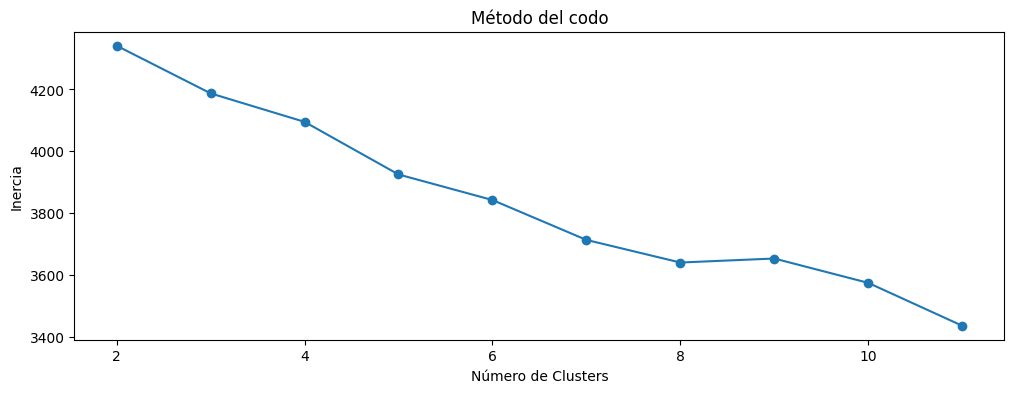

In [40]:
from sklearn.cluster import KMeans

inercia = []
range_k =  range(2, 12)
for k in range_k:
    km = KMeans(n_clusters= k, random_state= 42)
    km.fit(X_reduced)
    inercia.append(km.inertia_)

# Graficar el método del codo para KMeans
plt.figure(figsize=(12, 4))
plt.plot(range_k, inercia, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

El valor de k= 8 es ideal porque hasta este punto la inercia cae con fuerza, y a partir de ahí la mejora es muy pequeña, es decir cambia de tendencia en ese punto.

In [47]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
# KMeans K= 3
kmeans = KMeans(n_clusters=8, random_state=42)
label_kmeans = kmeans.fit_predict(X_reduced)

# Métricas
silhouette_kmeans = silhouette_score(X_reduced, label_kmeans)
davies_kmeans = davies_bouldin_score(X_reduced, label_kmeans)
calinski_kmeans = calinski_harabasz_score(X_reduced, label_kmeans)

# Imprimir
print(f'Silhouette Score: {silhouette_kmeans:.3f}')
print(f'Davies-Bouldin Score: {davies_kmeans:.3f}')
print(f'Calinski-Harabasz Score: {calinski_kmeans:.3f}')

Silhouette Score: 0.482
Davies-Bouldin Score: 2.893
Calinski-Harabasz Score: 1039.133


- Silhouette ≈ 0.48 Indica separación moderada entre clusters. Valores cercanos a 1 son óptimos; por debajo de 0.5 suele denotar solapamientos.

- Davies-Bouldin ≈ 2.89 Cuanto más bajo, mejor. Un DB alto (> 1–2) sugiere que los centroides están relativamente cerca o los clusters no son muy compactos.

- Calinski-Harabasz ≈ 1039 A mayor valor, mejor.

## **COMPARACIÓN ENTRE MODELOS**

A continuación se agrupan las métricas obtenidas para el modelo de tópicos (LDA) y el de clustering (K-Means) con 𝑘=8

**Modelo LDA**
- `Coherencia (0.7197)`, Muy buena coherencia semántica; tópicos interpetables.
- `Perplexity (25688.06)`, Nivel de "Sorpresa" en test, más bajo mejor.

**Modelo K-means**
- `Silhouette (0.482)`, Separación moderada.
- `Davies-Bouldin (2.893)`, Cluster menos compactos.
- `Calinski-Harabasz (1039.133)`, Indica estructura, necesita ser comparado con diferentes k.

Según los resultados obtenidos, la elección del modelo debe ajustarse al objetivo del análisis:

Para la extracción de temas, LDA se impone gracias a su alta coherencia semántica y la claridad interpretativa de sus tópicos.

En cambio, el clustering de documentos ofrece una separación moderada entre grupos, lo que indica la necesidad de afinar parámetros (por ejemplo, el número de clusters, el preprocesamiento o la reducción de dimensionalidad) para mejorar su desempeño.

En resumen, si el objetivo es identificar temas claros y cohesionados, LDA es la opción recomendada. Pero si se busca segmentar el corpus en agrupamientos de documentos bien diferenciados, conviene explorar y optimizar métodos de clustering.